**Implement a SVM to classify images of cats and dogs from the kaggle dataset**

In [7]:
# STEP 1: Upload the ZIP file
from google.colab import files
uploaded = files.upload()  # Upload 'train.zip'

# STEP 2: Unzip the file
import zipfile
import os

zip_path = 'train.zip'  # File you just uploaded
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Extract to /content/

# Now data is in: /content/train/cat/ and /content/train/dog/

# STEP 3: Import required libraries
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Saving train.zip to train.zip


In [8]:
!pip install scikit-image --quiet

In [9]:
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import os

def load_images_and_hog_features(base_path, img_size=64):
    X, y = [], []
    for class_name in ['cats', 'dogs']:
        folder_path = os.path.join(base_path, class_name)
        if not os.path.exists(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            continue
        for img_name in tqdm(os.listdir(folder_path), desc=f"Loading {class_name}"):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features = hog(
                gray,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                transform_sqrt=True
            )
            X.append(features)
            y.append(class_name)
    return np.array(X), np.array(y)

# 👇 Set base path according to your unzip location
data_path = '/content/train'
X, y = load_images_and_hog_features(data_path, img_size=64)
print(f"\n✅ Loaded {len(X)} samples with HOG features. Feature size: {X.shape[1]}")


Loading dogs: 100%|██████████| 10000/10000 [00:37<00:00, 266.16it/s]



✅ Loaded 20000 samples with HOG features. Feature size: 1764


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # cat=0, dog=1

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, verbose=True)
svm_model.fit(X_train, y_train)

[LibSVM]

SVC(kernel='linear', verbose=True)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = svm_model.predict(X_test)

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



✅ Accuracy: 0.7117

📄 Classification Report:
               precision    recall  f1-score   support

        cats       0.72      0.69      0.71      2019
        dogs       0.70      0.73      0.71      1981

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000


📊 Confusion Matrix:
 [[1402  617]
 [ 536 1445]]


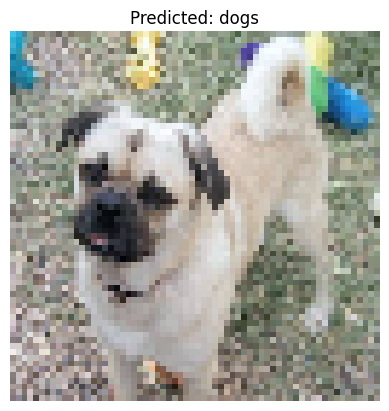

In [14]:
import matplotlib.pyplot as plt

def predict_new_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(
        gray, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True
    ).reshape(1, -1)
    pred = svm_model.predict(features)
    label = le.inverse_transform(pred)[0]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

predict_new_image('/content/dog_img.jpg')
